<a href="https://colab.research.google.com/github/TayJen/hackathon_algu2022/blob/master/H_ALGU_2022_Baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/Shareddrives/data_drive/H_Vladivostok2022
!pwd

/content/drive/Shareddrives/data_drive/H_Vladivostok2022
/content/drive/Shareddrives/data_drive/H_Vladivostok2022


## Загрузим нужные библиотеки

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import numpy as np

%matplotlib inline
mpl.rcParams['figure.facecolor'] = 'white'
np.random.seed(59)

### Считаем тренировочный набор

In [4]:
df_issues_train = pd.read_csv("./data/train/train_issues.csv")
df_emp = pd.read_csv("./data/employees.csv")

## Рассмотрим датасет поближе

In [5]:
df_issues_train.head(3)

,id,created,key,summary,project_id,assignee_id,creator_id,overall_worklogs
0,819952,2019-10-01 05:57:18.000,SM-10678,"UI тесты по заказу ""Добро КейДжи""",5,93,93,1800
1,819949,2019-10-01 05:59:45.000,SM-10679,"UI тесты раздела ""Профиль""",5,93,93,7200
2,819947,2019-10-01 06:00:38.000,SM-10680,"UI тесты раздела ""Личный счет""",5,93,93,14400


In [6]:
df_issues_train.shape

(9589, 8)

In [7]:
df_issues_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9589 entries, 0 to 9588
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                9589 non-null   int64 
 1   created           9589 non-null   object
 2   key               9589 non-null   object
 3   summary           9589 non-null   object
 4   project_id        9589 non-null   int64 
 5   assignee_id       9589 non-null   int64 
 6   creator_id        9589 non-null   int64 
 7   overall_worklogs  9589 non-null   int64 
dtypes: int64(5), object(3)
memory usage: 599.4+ KB


### Преобразование столбцов

Сделаем два столбца - день и месяц создания задачи

In [8]:
df_issues_train["month"] = df_issues_train.created.map(lambda x : int(x.split("-")[1]))
df_issues_train["day"] = df_issues_train.created.map(lambda x : int(x.split("-")[2].split()[0]))

Удалим не нужную информацию о работниках

In [9]:
df_emp = df_emp.drop(["active", "full_name", "salary_calculation_type", "passport"], axis = 1)

Обьединим два набора данных по id исполнителя

In [10]:
df_train = pd.merge(df_issues_train, df_emp, left_on="assignee_id", right_on="id", how='inner')
df_train = df_train.fillna(0)
df_train.shape

(9589, 19)

 Создадим список всех не числовых лейблов и взглянем на них

In [11]:
mass_object = df_train.dtypes[df_train.dtypes == "object"].index.values
df_train[mass_object].head(3)

,created,key,summary,position,hiring_type,payment_type,english_level
0,2019-10-01 05:57:18.000,SM-10678,"UI тесты по заказу ""Добро КейДжи""",Разработчик мобильных приложений,staff,fixed,0
1,2019-10-01 05:59:45.000,SM-10679,"UI тесты раздела ""Профиль""",Разработчик мобильных приложений,staff,fixed,0
2,2019-10-01 06:00:38.000,SM-10680,"UI тесты раздела ""Личный счет""",Разработчик мобильных приложений,staff,fixed,0


Взглянем на них поближе

In [12]:
df_train.hiring_type.value_counts()

staff        7005
0            1959
non_staff     625
Name: hiring_type, dtype: int64

In [13]:
df_train.payment_type.value_counts()

fixed     5765
0         2060
hourly    1764
Name: payment_type, dtype: int64

In [14]:
df_train.english_level.value_counts()

0     9055
B1     358
C1     176
Name: english_level, dtype: int64

Сменим им тип данных

In [15]:
cat_cols = ['payment_type', 
            'hiring_type',
            'english_level']

for cat in cat_cols:
    df_train[cat] = pd.Categorical(df_train[cat])
    df_train[cat].astype('category').cat.codes
    df_train[cat] = df_train[cat].cat.codes

Распределение различных значений

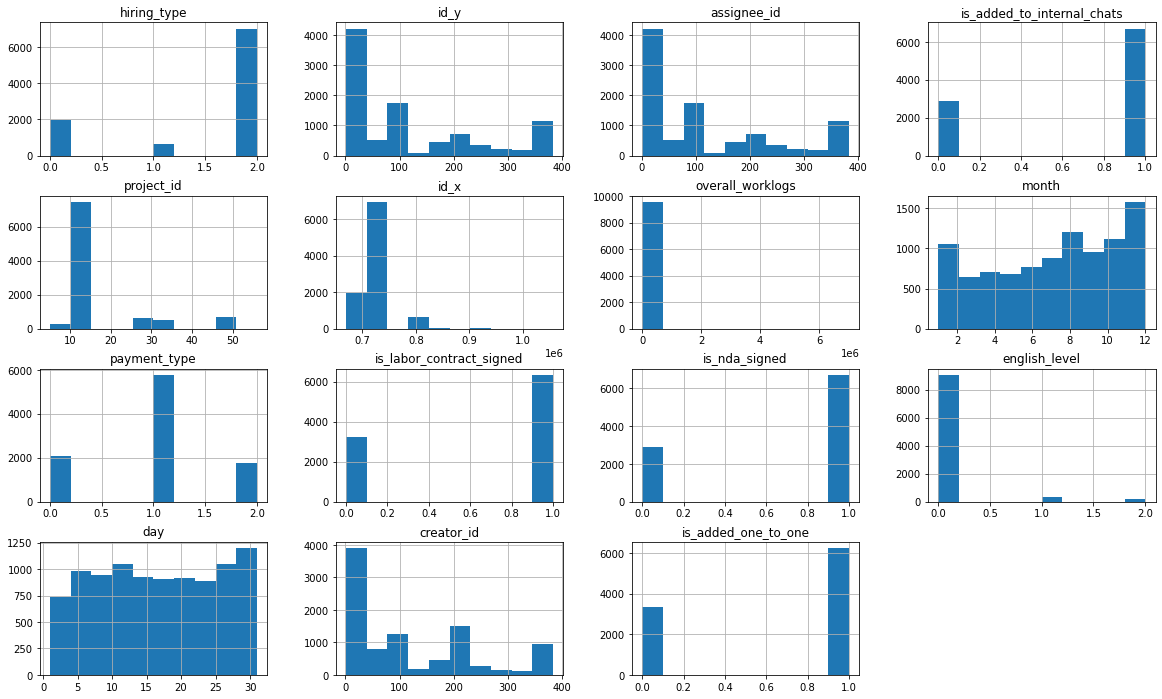

In [16]:
mass_object = df_train.dtypes[df_train.dtypes == "object"].index.values
features = list(set(df_train.columns.to_list()) - set(mass_object))

# with plt.style.context('seaborn-white'):
_ = df_train[features].hist(figsize=(20, 12))

Рассмотрим корреляцию всех признаков

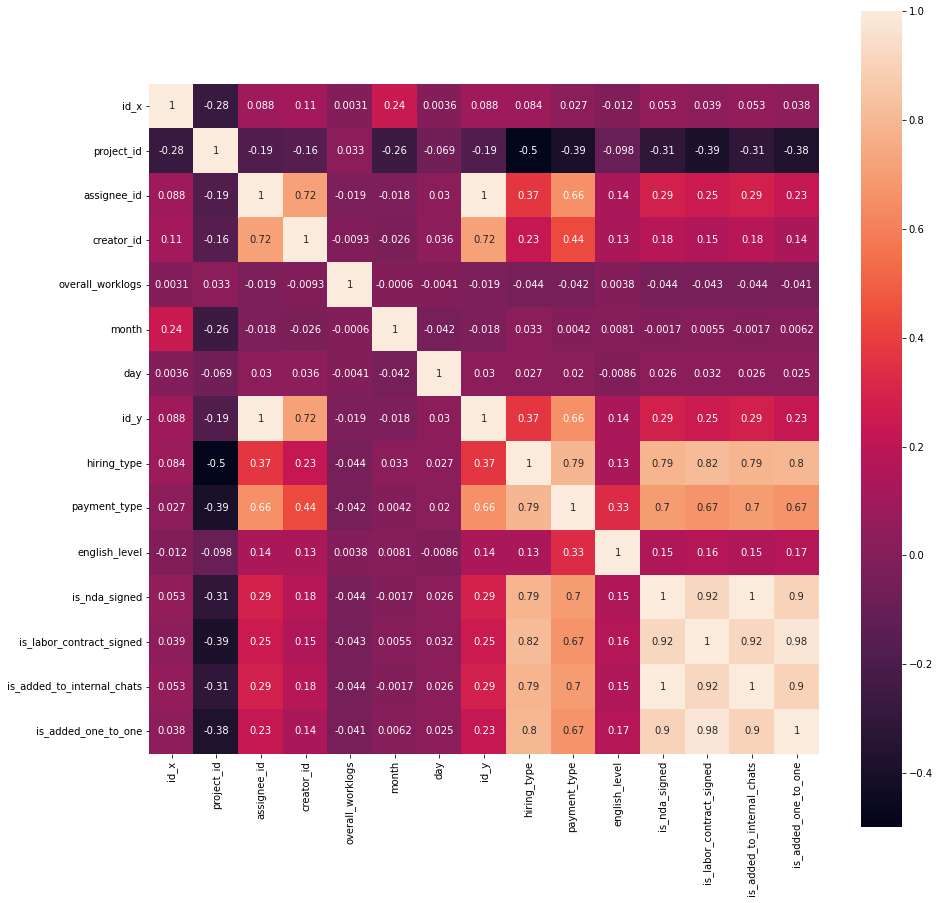

In [17]:
corr = df_train.corr()
# with plt.style.context('seaborn-white'):
plt.rcParams['figure.figsize'] = (15,15)
g = sns.heatmap(corr, square = True, annot=True)
plt.show()

## Работа с summary

In [18]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from nltk.corpus import wordnet
from pymystem3 import Mystem

m = Mystem()

In [19]:
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [20]:
!wget http://download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz
!tar -xvf mystem-3.0-linux3.1-64bit.tar.gz
!cp mystem /root/.local/bin/mystem

--2022-09-26 13:41:03--  http://download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz
Resolving download.cdn.yandex.net (download.cdn.yandex.net)... 5.45.205.244, 5.45.205.245, 5.45.205.241, ...
Connecting to download.cdn.yandex.net (download.cdn.yandex.net)|5.45.205.244|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: http://cachev2-spb02.cdn.yandex.net/download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz?lid=122 [following]
--2022-09-26 13:41:04--  http://cachev2-spb02.cdn.yandex.net/download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz?lid=122
Resolving cachev2-spb02.cdn.yandex.net (cachev2-spb02.cdn.yandex.net)... 37.140.137.4, 2a02:6b8:0:2221::304
Connecting to cachev2-spb02.cdn.yandex.net (cachev2-spb02.cdn.yandex.net)|37.140.137.4|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16457938 (16M) [application/octet-stream]
Saving to: ‘mystem-3.0-linux3.1-64bit.tar.gz.5’

mystem-3.0-linux3.1 100%[===

In [21]:
import re

lemmatizer = WordNetLemmatizer()
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()


def clear_text(text):
    t = re.sub(r'[^a-zA-Z0-9а-яА-ЯёЁ\' ]', ' ', text)
    t = ' '.join(t.split())
    return t

def lemmatize_text(text):
    tokens = m.lemmatize(text.lower())
    tokens = [token for token in tokens if token != '\n']
    text = " ".join(tokens)
    return text

def pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:         
        return None

def lemmatize_with_pos(text):
    pos_tagged = nltk.pos_tag(w_tokenizer.tokenize(text))
    wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tagged))
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            lemmatized_sentence.append(word)
        else:       
            lemmatized_sentence.append(lemmatizer.lemmatize(word, pos=tag))
    lemmatized_sentence = " ".join(lemmatized_sentence)
    return lemmatized_sentence



df_train['clear_summary'] = df_train['summary'].apply(clear_text)
df_train['clear_summary'] = df_train['clear_summary'].str.lower()
df_train['lemm_summary'] = df_train['clear_summary'].apply(lemmatize_text)
df_train['lemm_summary'] = df_train['lemm_summary'].apply(lemmatize_with_pos)

In [22]:
from nltk.corpus import stopwords

nltk.download('stopwords')
stopwords_rus = stopwords.words("russian")
stopwords_eng = stopwords.words('english')
stopwords_all = stopwords_rus + stopwords_eng

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Выделим выборки

Удалим все лишние столбцы из выборки

In [23]:
mass_object = ['created', 'key', 'summary', 'clear_summary', 'position']
stuff = ["id_x", "id_y", "overall_worklogs"]

mass_object = np.append(mass_object, stuff)
X = df_train.drop(mass_object, axis=1)
y = np.log(df_train[["overall_worklogs"]])
X.head()

,project_id,assignee_id,creator_id,month,day,hiring_type,payment_type,english_level,is_nda_signed,is_labor_contract_signed,is_added_to_internal_chats,is_added_one_to_one,lemm_summary
0,5,93,93,10,1,2,1,0,1,1,1,1,ui тест по заказ добро кейджи
1,5,93,93,10,1,2,1,0,1,1,1,1,ui тест раздел профиль
2,5,93,93,10,1,2,1,0,1,1,1,1,ui тест раздел личный счет
3,5,93,93,10,1,2,1,0,1,1,1,1,ui тест раздел новость
4,5,93,93,10,1,2,1,0,1,1,1,1,ui тест раздел зона скидка и доплата


In [24]:
y

,overall_worklogs
0,7.495542
1,8.881836
2,9.574983
3,6.802395
4,6.802395
...,...
9584,9.798127
9585,9.692767
9586,8.188689
9587,8.748305


In [25]:
X.shape

(9589, 13)

In [45]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=59)
X_train.shape, X_val.shape

((8150, 13), (1439, 13))

In [46]:
from sklearn.feature_extraction.text import TfidfVectorizer


count_tf_idf = TfidfVectorizer(stop_words=stopwords_all)

X_train_new = count_tf_idf.fit_transform(X_train['lemm_summary'])
feature_names_tf = list(map(lambda x: x + '_tf', count_tf_idf.get_feature_names_out()))
X_train_new_df = pd.DataFrame(X_train_new.toarray(), columns=feature_names_tf)
X_train.drop('lemm_summary', axis=1, inplace=True)
X_train.reset_index(inplace=True, drop=True)
X_train = pd.concat([X_train, X_train_new_df], axis=1)

X_val_new = count_tf_idf.transform(X_val['lemm_summary'])
X_val_new_df = pd.DataFrame(X_val_new.toarray(), columns=feature_names_tf)
X_val.drop('lemm_summary', axis=1, inplace=True)
X_val.reset_index(inplace=True, drop=True)
X_val = pd.concat([X_val, X_val_new_df], axis=1)

X_train.shape, X_val.shape

((8150, 4533), (1439, 4533))

In [54]:
y_train = y_train.values
y_val = y_val.values

### XGBoost

In [55]:
from xgboost import XGBRegressor
from sklearn.metrics import r2_score


model = XGBRegressor(random_state=59)
model.fit(X_train, y_train)

[13:51:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(random_state=59)

In [56]:
pred = model.predict(X_val)
score = r2_score(y_val, pred)
score

0.1642207730057439

## Сабмит на сайт

In [57]:
df_issues_test = pd.read_csv("./data/test/test_issues.csv")

In [58]:
df_issues_test["month"] = df_issues_test.created.map(lambda x : int(x.split("-")[1]))
df_issues_test["day"] = df_issues_test.created.map(lambda x : int(x.split("-")[2].split()[0]))

In [59]:
df_issues_test.head()

,id,created,key,summary,project_id,assignee_id,creator_id,month,day
0,675975,2020-01-15 09:52:57.000,SM-11140,Выгрузить все mp3 файлы звонков на диск,5,112,112,1,15
1,675972,2020-01-15 09:54:35.000,SM-11141,Удалить файлы mp3 звонков с сервера до 01.01.2019,5,112,112,1,15
2,675965,2020-01-16 04:46:17.000,SM-11144,Удалить окно выбора тарифов и перенести функци...,5,94,54,1,16
3,675961,2020-01-16 11:12:18.000,SM-11146,При авторизации пользователь/водитель не видит...,5,94,94,1,16
4,675955,2020-01-17 05:19:39.000,SM-11150,Основные проблемы по корп. отделу (по состояни...,5,1,54,1,17


In [60]:
df_test = pd.merge(df_issues_test, df_emp, left_on="assignee_id", right_on="id", how='inner')
df_test = df_test.fillna(0)
df_test.head()

,id_x,created,key,summary,project_id,assignee_id,creator_id,month,day,id_y,position,hiring_type,payment_type,english_level,is_nda_signed,is_labor_contract_signed,is_added_to_internal_chats,is_added_one_to_one
0,675975,2020-01-15 09:52:57.000,SM-11140,Выгрузить все mp3 файлы звонков на диск,5,112,112,1,15,112,DevOps инженер,staff,fixed,0,0,0,0,0
1,675972,2020-01-15 09:54:35.000,SM-11141,Удалить файлы mp3 звонков с сервера до 01.01.2019,5,112,112,1,15,112,DevOps инженер,staff,fixed,0,0,0,0,0
2,675917,2020-02-01 02:24:11.000,SM-11174,Водители не могут нажать на кнопку «на месте» ...,5,112,1,2,1,112,DevOps инженер,staff,fixed,0,0,0,0,0
3,675915,2020-02-01 02:27:30.000,SM-11175,Категория тарифа в карточке тарифа не всегда а...,5,112,1,2,1,112,DevOps инженер,staff,fixed,0,0,0,0,0
4,675912,2020-02-03 05:05:30.000,SM-11176,Добавить ip адрес с список разрешённых к подкл...,5,112,1,2,3,112,DevOps инженер,staff,fixed,0,0,0,0,0


In [61]:
cat_cols = ['payment_type', 
            'hiring_type',
            'english_level']

for cat in cat_cols:
    df_test[cat] = pd.Categorical(df_test[cat])
    df_test[cat].astype('category').cat.codes
    df_test[cat] = df_test[cat].cat.codes

In [62]:
df_test['clear_summary'] = df_test['summary'].apply(clear_text)
df_test['clear_summary'] = df_test['clear_summary'].str.lower()
df_test['lemm_summary'] = df_test['clear_summary'].apply(lemmatize_text)
df_test['lemm_summary'] = df_test['lemm_summary'].apply(lemmatize_with_pos)

In [63]:
mass_object = ['created', 'key', 'summary', 'clear_summary', 'position']
stuff = ["id_x", "id_y"]

mass_object = np.append(mass_object, stuff)

X_test = df_test.drop(mass_object, axis=1)
X_test.head()

,project_id,assignee_id,creator_id,month,day,hiring_type,payment_type,english_level,is_nda_signed,is_labor_contract_signed,is_added_to_internal_chats,is_added_one_to_one,lemm_summary
0,5,112,112,1,15,2,1,0,0,0,0,0,выгружать весь mp3 файл звонок на диск
1,5,112,112,1,15,2,1,0,0,0,0,0,удалять файл mp3 звонок с сервер до 01 01 2019
2,5,112,1,2,1,2,1,0,0,0,0,0,водитель не мочь нажимать на кнопка на место и...
3,5,112,1,2,1,2,1,0,0,0,0,0,категория тариф в карточка тариф не всегда авт...
4,5,112,1,2,3,2,1,0,0,0,0,0,добавлять ip адрес с список разрешать к подклю...


In [64]:
X_test_new = count_tf_idf.transform(X_test['lemm_summary'])
X_test_new_df = pd.DataFrame(X_test_new.toarray(), columns=feature_names_tf)
X_test.drop('lemm_summary', axis=1, inplace=True)
X_test.reset_index(inplace=True, drop=True)
X_test = pd.concat([X_test, X_test_new_df], axis=1)

X_test.shape

(1070, 4533)

In [65]:
prediction_site = np.rint(np.exp(model.predict(X_test))).astype('int64')
prediction_site

array([ 6671,  6671,  6690, ..., 13481, 11819,  8340])

### Взглянем на пример сабмишна и сделаем свой для сайта

In [66]:
df_sample = pd.read_csv('./data/sample_solution.csv')
df_sample.head()

,id,overall_worklogs
0,675975,0
1,675972,0
2,675965,0
3,675961,0
4,675955,0


In [67]:
len(prediction_site), len(df_sample)

(1070, 1070)

In [68]:
df_sample.overall_worklogs = prediction_site
df_sample.head()

,id,overall_worklogs
0,675975,6671
1,675972,6671
2,675965,6690
3,675961,6637
4,675955,6637


In [69]:
# !mkdir solutions

In [70]:
df_sample.to_csv('./solutions/xgb_tfidf_baseline_feats.csv', index=False)

### Проверка предсказания

In [71]:
df_solution = pd.read_csv('./solutions/xgb_tfidf_baseline_feats.csv')
df_solution.head()

,id,overall_worklogs
0,675975,6671
1,675972,6671
2,675965,6690
3,675961,6637
4,675955,6637


### Простое решение с медианой

In [ ]:
median = int(df_train.overall_worklogs.median())
median

7200

In [ ]:
df_dumb_solution = pd.read_csv('./data/sample_solution.csv')
df_dumb_solution.overall_worklogs = median
df_dumb_solution.head()

,id,overall_worklogs
0,675975,7200
1,675972,7200
2,675965,7200
3,675961,7200
4,675955,7200


In [ ]:
df_dumb_solution.to_csv('./solutions/dumb_solution.csv', index=False)

### Простое решение со средним

In [ ]:
mean = df_train.overall_worklogs.mean()
mean

17243.688392950255

In [ ]:
df_dumb_solution = pd.read_csv('./data/sample_solution.csv')
df_dumb_solution.overall_worklogs = mean
df_dumb_solution.head()

,id,overall_worklogs
0,675975,17243.688393
1,675972,17243.688393
2,675965,17243.688393
3,675961,17243.688393
4,675955,17243.688393


In [ ]:
df_dumb_solution.to_csv('./solutions/dumb_solution_mean.csv', index=False)